Model: BERT tokenizer + RNN (Linear, Tanh) 

Incorporated some code from:https://www.kaggle.com/barelydedicated/yelp-review-predictions-using-huggingface-bert/notebook

In [ ]:
# Set to your own working directory (don't need in colab)
#%cd /Users/kelsey/yelp

### Installs & Imports: 

In [ ]:
# Installed the following, which I did not have 

!pip install transformers==3.5.1
!pip install bert-for-tf2
!pip install sentencepiece
!pip install bert
!pip install bert-tensorflow
!pip install seaborn
!pip install tensorflow
!pip install tensorflow_hub
# FOR COLAB ONLY
!pip install torch==1.4.0

In [3]:
# Import all of the following: 
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import tensorflow as tf
import tensorflow_hub as hub
from datetime import datetime
from transformers import *
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
import time
import bert
from bert import optimization
from bert import tokenization
from sklearn.metrics import confusion_matrix
import itertools

### The Data

In [7]:
# Upload .csv of dataset (cleaning is in another notebook)
yelp = pd.read_csv("yelp_balanced.csv")

In [8]:
# BERT tokenizer can't take any NaN's, so fill with string "no text"
yelp = yelp.fillna("no text")

In [9]:
# Train-test split
x = yelp['text'].tolist()
y = yelp['stars'].tolist()

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, 
                                                    random_state=42)

data_train = pd.DataFrame()
data_train['text'] = x_train
data_train['stars'] = y_train

data_test = pd.DataFrame()
data_test['text'] = x_test
data_test['stars'] = y_test

### The Model 

Create the Model

In [10]:
# Create tokenizer using pretrained BERT
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# Create the model 
hidden_size = 200
model = BertForSequenceClassification.from_pretrained('bert-base-cased', 
                                                      num_labels=hidden_size)

# Add Tanh Layer
model.classifier.add_module('bert_activation', nn.Tanh())

# Add Linear Layer 
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

# Print # of parameters
FINE_TUNE = True
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model.cuda();

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Total model trainable parameters 108465077
Total head trainable parameters 154805


In [11]:
# Check to see what the model created
model.classifier

Linear(
  in_features=768, out_features=200, bias=True
  (bert_activation): Tanh()
  (prediction): Linear(in_features=200, out_features=5, bias=True)
)

In [12]:
# Check the tokenizer on a single sentence 
tokenized = tokenizer.tokenize('I have always loved the food here')
print(tokenized)
print(tokenizer.encode(tokenized, add_special_tokens=False))
print(tokenizer.encode(tokenized, add_special_tokens=True))

['I', 'have', 'always', 'loved', 'the', 'food', 'here']
[146, 1138, 1579, 3097, 1103, 2094, 1303]
[101, 146, 1138, 1579, 3097, 1103, 2094, 1303, 102]


In [13]:
# Create "features" function 
def get_features(df, text_col, label_col):
    l = [InputExample(guid=idx, text_a=df.loc[idx, text_col], label=df.loc[idx, label_col]) for 
       idx, row in tqdm(df.iterrows(), total=df.shape[0])]
    features = glue_convert_examples_to_features(examples=l, 
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].values,
                                    output_mode='regression')

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [14]:
# Apply "features" function to training set and test set
train_dataset = get_features(data_train, 'text', 'stars')
test_dataset = get_features(data_test, 'text', 'stars')

  0%|          | 0/120000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/30000 [00:11<?, ?it/s]

In [15]:
# Train-test split again into train and eval
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), 
                                      random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [16]:
# Create model
model(input_ids=train_dataset[:2][0].cuda(), 
      attention_mask=train_dataset[:2][1].cuda(), 
      labels=train_dataset[:2][2].cuda());  

### Training

In [17]:
# Setup for training: select batch size, when to print gradient, 
# num epochs, learning rate, optimizer

batch_size = 16
gradient_every = 32
assert batch_size <= gradient_every and gradient_every % batch_size == 0

accumulation_steps = gradient_every//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

epochs = 5
lr = 0.002
optimizer = AdamW(model.classifier.parameters(), lr=lr)  

In [18]:
# Initialize losses 
tr_losses = []
v_losses = []

In [19]:
# TRAINING
for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    # initialize epoch loss
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, 
                                                                 total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(), 
                     'attention_mask': attention_mask.cuda(), 
                     'labels': labels.cuda()} 
        
        loss, _ = model(**feed_dict)

        # gradient accumulation
        epoch_tr_losses.append(loss.item())
        loss = loss/accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')
  
    """ Validation stage """
    epoch_v_losses = [] 
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, 
                                                                     total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(), 
                         'attention_mask': attention_mask.cuda(), 
                         'labels': labels.cuda()}  

            loss, pred = model(**feed_dict)
            epoch_v_losses.append(loss.item())
        v_losses.append(np.mean(epoch_v_losses))
    print(f'validation BCE loss: {np.mean(epoch_v_losses)}')

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

epoch 1


batch:   0%|          | 0/6750 [00:00<?, ?it/s]

train NLL loss: 1.3596585071351792


val batch:   0%|          | 0/375 [00:00<?, ?it/s]

validation BCE loss: 1.2499289803504945
epoch 2


batch:   0%|          | 0/6750 [00:00<?, ?it/s]

train NLL loss: 1.270347015009986


val batch:   0%|          | 0/375 [00:00<?, ?it/s]

validation BCE loss: 1.2769222048123678
epoch 3


batch:   0%|          | 0/6750 [00:00<?, ?it/s]

train NLL loss: 1.246818550268809


val batch:   0%|          | 0/375 [00:00<?, ?it/s]

validation BCE loss: 1.2495851322809854
epoch 4


batch:   0%|          | 0/6750 [00:00<?, ?it/s]

train NLL loss: 1.2358035491484183


val batch:   0%|          | 0/375 [00:00<?, ?it/s]

validation BCE loss: 1.1856376053492228
epoch 5


batch:   0%|          | 0/6750 [00:00<?, ?it/s]

train NLL loss: 1.226317029900021


val batch:   0%|          | 0/375 [00:00<?, ?it/s]

validation BCE loss: 1.177956046740214


### Predictions

In [20]:
# Initialize batch predictions + actual 
batch_predictions, batch_actual = [], []

# Fill in batch predictions + actual 
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(
        tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()}
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

val batch:   0%|          | 0/938 [00:00<?, ?it/s]

In [21]:
# Total predictions + actual 
predictions = np.array([i for k in batch_predictions for i in k ])
predictions = np.argmax(predictions, axis=1)
actual = np.array([i for k in batch_actual for i in k ])

In [22]:
# Accuracy on Test Data 
sum(predictions == actual)/len(actual)

0.4787666666666667

In [23]:
# Accuracy on Test Data allowing +/- one star 
(sum(predictions == actual) + sum(predictions == (actual + 1)) + sum(
    predictions == (actual - 1)))/len(actual)

0.8477333333333333

In [24]:
# Confusion Matrix function
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

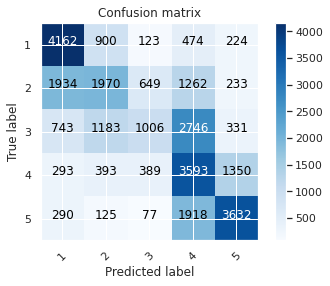

In [25]:
# Compute 
confusion_mtx = confusion_matrix(actual, predictions) 

# Plot 
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()

### Testing Linguistic Examples

In [26]:
# Read in examples csv 
examples = pd.read_csv("example_sentences - examples_combined.csv")
examples = examples.fillna("no text")

In [27]:
examples.columns

Index(['Unnamed: 0', 'review_id', 'user_id', 'business_id', 'stars', 'date',
       'text', 'useful', 'funny', 'cool', 'contradictory', 'figurative',
       'confusing', 'qualifier'],
      dtype='object')

In [28]:
# Divide into four types of examples
examples_qualifier = examples[examples['qualifier'] == 1]
examples_contradictory = examples[examples['contradictory'] == 1]
examples_confusing = examples[examples['confusing'] == 1]
examples_figurative = examples[examples['figurative'] == 1]

In [29]:
# create features + dataloader just like for train & test data
examples_qualifier_dataset = get_features(examples_qualifier, 'text', 'stars')
examples_qualifier_dataloader = DataLoader(examples_qualifier_dataset)

examples_contradictory_dataset = get_features(examples_contradictory, 'text', 'stars')
examples_contradictory_dataloader = DataLoader(examples_contradictory_dataset)

examples_confusing_dataset = get_features(examples_confusing, 'text', 'stars')
examples_confusing_dataloader = DataLoader(examples_confusing_dataset)

examples_figurative_dataset = get_features(examples_figurative, 'text', 'stars')
examples_figurative_dataloader = DataLoader(examples_figurative_dataset)

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

In [30]:
# Predictions: Qualifiers 
predictions_qualifier, pred_actual0 = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(
        tqdm(examples_qualifier_dataloader, total=len(examples_qualifier_dataloader), 
             desc = "example")): 
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()}
        
        pred0 = model(**feed_dict)[0].cpu()
        predictions_qualifier.append(pred0.numpy())


# Predictions: Contradictory 
predictions_contradictory, pred_actual1 = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(
        tqdm(examples_contradictory_dataloader, total=len(examples_contradictory_dataloader), 
             desc = "example")): 
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()}
        
        pred = model(**feed_dict)[0].cpu()
        predictions_contradictory.append(pred.numpy())


# Predictions: Confusing 
predictions_confusing, pred_actual2 = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(
        tqdm(examples_confusing_dataloader, total=len(examples_confusing_dataloader), 
             desc = "example")): 
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()}
        
        pred = model(**feed_dict)[0].cpu()
        predictions_confusing.append(pred.numpy())


# Predictions: Figurative
predictions_figurative, pred_actual3 = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(
        tqdm(examples_figurative_dataloader, total=len(examples_figurative_dataloader), 
             desc = "example")): 
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()}
        
        pred = model(**feed_dict)[0].cpu()
        predictions_figurative.append(pred.numpy())

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

In [ ]:
# Create predictions vectors & add to dataframes
predictions_qualifier1  = np.array([i for k in predictions_qualifier for i in k])
examples_qualifier['predictions'] = np.argmax(predictions_qualifier1, axis = 1) + 1

predictions_contradictory1  = np.array([i for k in predictions_contradictory for i in k])
examples_contradictory['predictions'] = np.argmax(predictions_contradictory1, axis = 1) + 1

predictions_confusing1  = np.array([i for k in predictions_confusing for i in k])
examples_confusing['predictions'] = np.argmax(predictions_confusing1, axis = 1) + 1

predictions_figurative1  = np.array([i for k in predictions_figurative for i in k])
examples_figurative['predictions'] = np.argmax(predictions_figurative1, axis = 1) + 1

In [32]:
# Look at matrix (Example)
examples_qualifier[['text', 'stars', 'predictions']]

,text,stars,predictions
0,Service was incredible! Food was simple but no...,2,3
4,Worst service ever. Food is really good but wa...,1,2
16,I have never been disappointed. Food is home ...,5,5
19,It's not my favorite sushi spot but it's very ...,3,4
24,Yet again my first time visiting another lunch...,2,2
32,not my favorite or even go to place \n the foo...,2,3
34,So so. Definitely did not live up to the hype....,2,4
35,Not sure what all the hype on this place is ab...,2,2
36,We have been here several times for Sunday Sup...,3,1
39,Cute space and decor - this place has potentia...,2,2


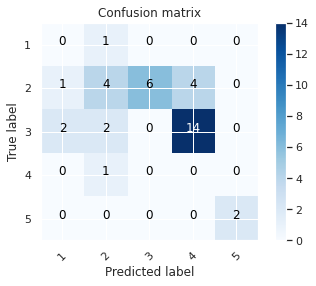

In [33]:
# Confusion Matrix: Qualifiers
# Compute 
confusion_matrix_qualifier = confusion_matrix(examples_qualifier["stars"], 
                                              examples_qualifier["predictions"])

# Plot 
plot_confusion_matrix(confusion_matrix_qualifier, classes = range(1,6))
plt.show()

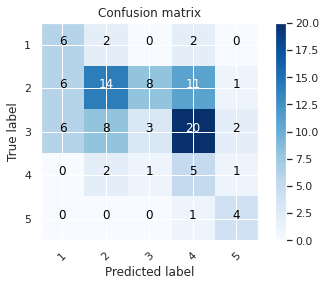

In [34]:
# Confusion Matrix: Contradictory
# Compute 
confusion_matrix_contradictory = confusion_matrix(examples_contradictory["stars"], 
                                              examples_contradictory["predictions"])

# Plot 
plot_confusion_matrix(confusion_matrix_contradictory, classes = [1, 2, 3, 4, 5])
plt.show()

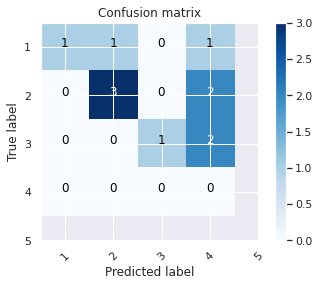

In [35]:
# Confusion Matrix: Confusing
# Compute 
confusion_matrix_confusing = confusion_matrix(examples_confusing["stars"], 
                                              examples_confusing["predictions"])

# Plot 
plot_confusion_matrix(confusion_matrix_confusing, classes = [1, 2, 3, 4, 5])
plt.show()

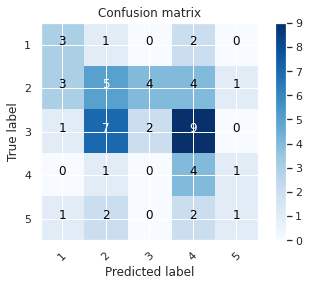

In [36]:
# Confusion Matrix: Figurative
# Compute 
confusion_matrix_figurative = confusion_matrix(examples_figurative["stars"], 
                                              examples_figurative["predictions"])

# Plot 
plot_confusion_matrix(confusion_matrix_figurative, classes = [1, 2, 3, 4, 5])
plt.show()

In [ ]:
# Accuracy: Confusing
sum(examples_confusing["stars"] == examples_confusing["predictions"])/len(examples_confusing["stars"])

In [ ]:
# Accuracy: Contradictory 
sum(examples_contradictory["stars"] == examples_contradictory["predictions"])/len(examples_contradictory["stars"])

In [ ]:
# Accuracy: Qualifiers
sum(examples_qualifier["stars"] == examples_qualifier["predictions"])/len(examples_qualifier["stars"])

In [ ]:
# Accuracy: Figurative
sum(examples_figurative["stars"] == examples_figurative["predictions"])/len(examples_figurative["stars"])

In [41]:
# Write to .csv
example_results = pd.ExcelWriter('example_sentences.xls')

# Write each dataframe to a different worksheet.
examples_qualifier.to_excel(example_results, sheet_name='qualifiers')
examples_confusing.to_excel(example_results, sheet_name='confusing')
examples_contradictory.to_excel(example_results, sheet_name='contradictory')
examples_figurative.to_excel(example_results, sheet_name = 'figurative')

example_results.save()

### Word Removal Experiment

In [42]:
def short_extract(df_extra):
    import random
    for ix, review in enumerate(df_extra["text"].values):
        r = review.split()
        for i in range(0, len(r)//5): #20 % of words
            r.pop(random.randrange(len(r)))
        df_extra["text"].values[ix] = " ".join(r)
    return df_extra

def create_dataloader(data):
    tmp = get_features(data, 'text', 'stars')
    return DataLoader(tmp)

def make_predictions(dataloader):
    pred = []
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(
            tqdm(dataloader, total=len(dataloader), 
                 desc = "example")): 
            feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda()}

            pred0 = model(**feed_dict)[0].cpu()
            pred.append(pred0.numpy())
    return pred

In [44]:
# Loop 20 times
n_iter = 20
edge_ = []*n_iter
for i in range(n_iter):
    examples = short_extract(examples.copy(deep = True))

    examples_qualifier_dataloader = \
        create_dataloader(examples[examples['qualifier'] == 1])
    examples_contradictory_dataloader = \
        create_dataloader(examples[examples['contradictory'] == 1])
    examples_confusing_dataloader = \
        create_dataloader(examples[examples['confusing'] == 1])
    examples_figurative_dataloader = \
        create_dataloader(examples[examples['figurative'] == 1])

    predictions_qualifier1 = \
        np.array([i for k in make_predictions(\
            examples_qualifier_dataloader) for i in k])
    examples_qualifier['predictions'] = \
        np.argmax(predictions_qualifier1, axis = 1) + 1

    predictions_contradictory1  = \
        np.array([i for k in make_predictions(\
            examples_contradictory_dataloader) for i in k])
    examples_contradictory['predictions'] = \
        np.argmax(predictions_contradictory1, axis = 1) + 1

    predictions_confusing1  = \
        np.array([i for k in make_predictions(\
            examples_confusing_dataloader) for i in k])
    examples_confusing['predictions'] = \
        np.argmax(predictions_confusing1, axis = 1) + 1

    predictions_figurative1  = \
        np.array([i for k in make_predictions(\
            examples_figurative_dataloader) for i in k])
    examples_figurative['predictions'] = \
        np.argmax(predictions_figurative1, axis = 1) + 1
        
    tmp = []
    for example_type in (examples_contradictory, examples_figurative,\
                  examples_qualifier):
        score = sum(example_type["stars"] == \
                    example_type["predictions"])/len(example_type["stars"])
        tmp.append(score)
    edge_.append(tmp)

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


  0%|          | 0/103 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/54 [00:00<?, ?it/s]

example:   0%|          | 0/37 [00:00<?, ?it/s]

example:   0%|          | 0/103 [00:00<?, ?it/s]

example:   0%|          | 0/11 [00:00<?, ?it/s]

example:   0%|          | 0/54 [00:00<?, ?it/s]

In [45]:
# Save experiment
import csv
file = open('bert_experiment.csv', "w",newline = "")

with file: 
  write = csv.writer(file)
  write.writerows(edge_)

In [47]:
# Save model 
torch.save(model, '/content/model')